# **Importing Dependencies**

In [1]:
# !pip install pydot pydotplus
# !apt-get install graphviz

In [2]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 2.2 MB/s eta 0:00:00


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

# import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, callbacks

import warnings
warnings.filterwarnings("ignore")

# **Loading Dataset**

In [4]:
!pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sainikhil26","key":"8f78f14d4a3198fa9dfe196db096ea60"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 88% 30.0M/34.1M [00:00<00:00, 156MB/s] 
100% 34.1M/34.1M [00:00<00:00, 154MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/alzheimers-dataset-4-class-of-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [12]:
base_dir = "/content/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']


In [13]:
CLASSES = sorted(os.listdir(train_dir))
CLASSES

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# **Utilities**

In [14]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """

    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))

    # get a batch of images
    x,y = next(generator)

    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))

In [15]:
def plot_class_distribution(labels, class_names):
    class_num = dict(zip(range(len(class_names)), class_names))
    labels = [class_num[i] for i in np.argmax(labels, axis=1)]

    plt.figure(figsize=(15, 8))
    ax = sns.countplot(x=labels, palette='Set1')
    ax.set_xlabel("Class", fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    plt.title('The Number of Samples for Each Class', fontsize=18)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [16]:
def model_creation(model):
    for layer in model.layers:
        layer.trainable = False
    model = Sequential([
        model,
        Flatten(),
        Dense(4,activation="softmax")
    ])
    return model

In [17]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

In [18]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

CALLBACKS = [my_callback, rop_callback]

In [19]:
EPOCHS = 100
IMG_SIZE = 224
IMAGE_SIZE = [224,224]
DIM = (IMG_SIZE,IMG_SIZE)

In [38]:
def print_model_metrics(model,X_train,y_train,X_test,y_test):
  train_scores = model.evaluate(X_train, y_train)
  # val_scores = model.evaluate(X_val, y_val)
  test_scores = model.evaluate(X_test, y_test)

  print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
  # print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
  print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [21]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(30, 5))
    ax = ax.ravel()

    for i, metric in enumerate(["acc", "auc", "loss"]):
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

    plt.show()

In [22]:
def roundoff(arr):
    """Round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

def apply_roundoff_to_predictions(predictions):
    """Apply roundoff function to each predicted label array."""
    rounded_predictions = []
    for labels in predictions:
        labels = roundoff(labels)
        rounded_predictions.append(labels)
    return rounded_predictions

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot confusion matrix.

    Args:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - classes (list): List of class names.
    """
    conf_arr = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=classes,
                     yticklabels=classes)

    plt.title('Alzheimer\'s Disease Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show(ax)

In [24]:
def print_metrics(test_ls,pred_ls):
  print("Balanced Accuracy Score : {} %".format(round(BAS(test_ls,pred_ls)*100,2)))
  print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls,pred_ls)*100,2)))

# **Data Augmentation**

In [25]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=work_dir, target_size=DIM, batch_size=6500, shuffle=True)

Found 6400 images belonging to 4 classes.


# **Visualizing Data**

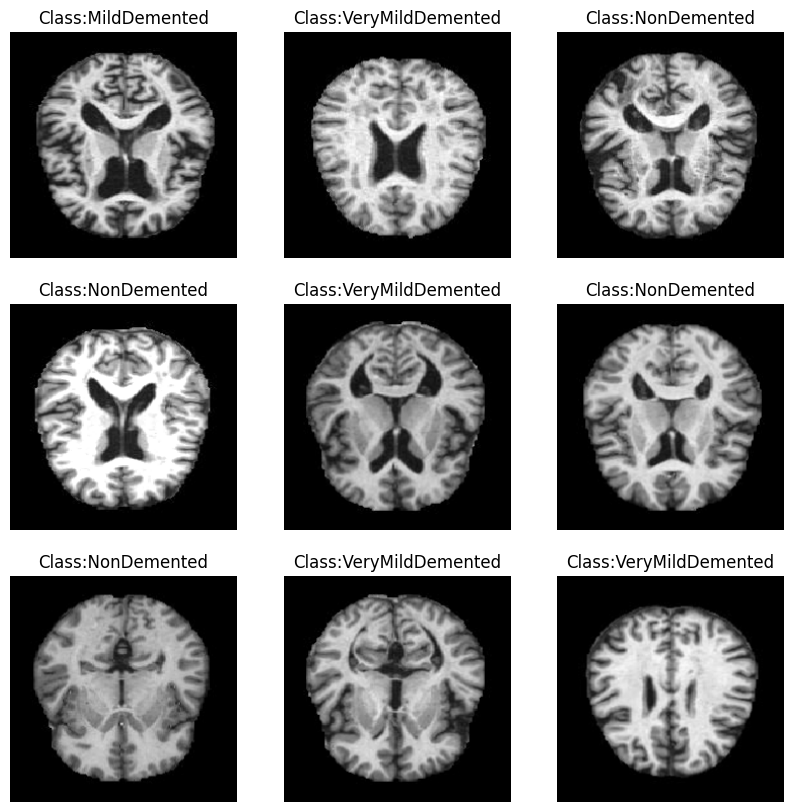

In [26]:
show_images(train_data_gen)

# **Preparing Training and Testing Data**

In [27]:
train_data, train_labels = next(train_data_gen)

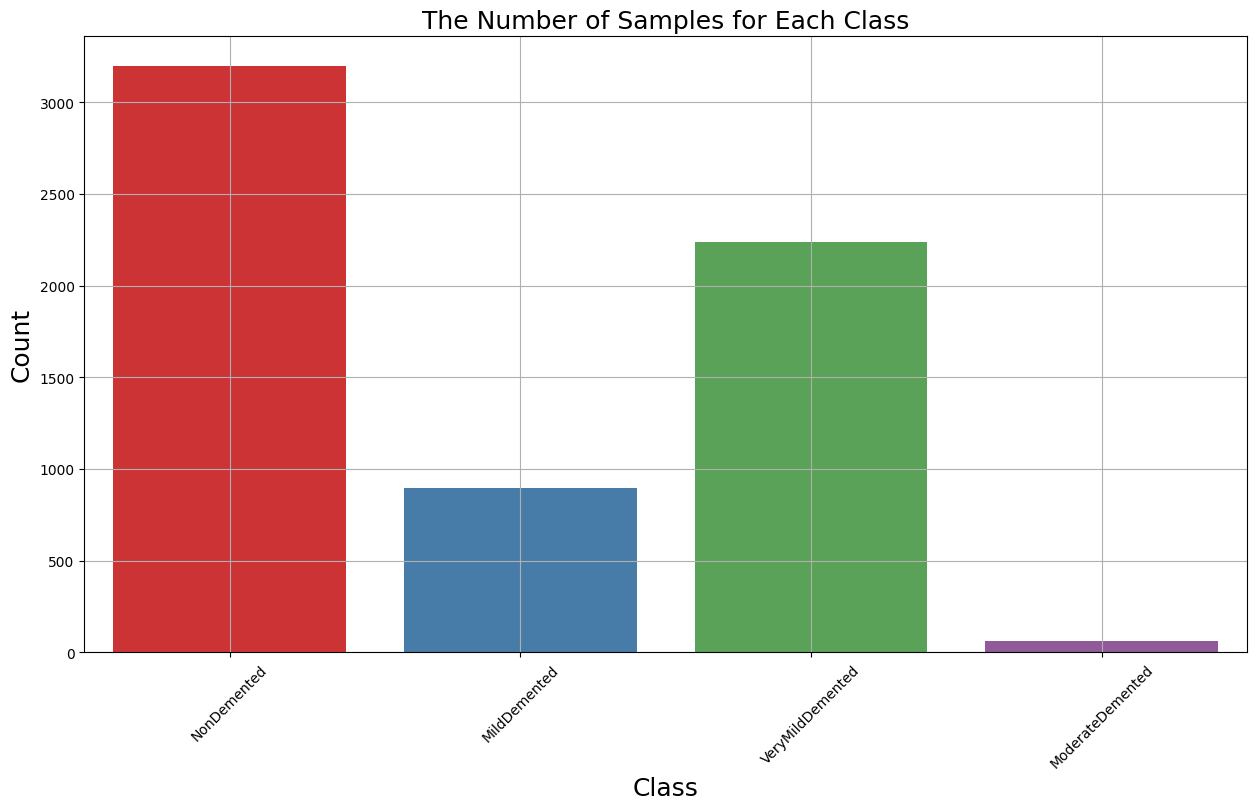

In [28]:
plot_class_distribution(train_labels,CLASSES)

**From this bar graph it can be seen that the classes are not evenly distributed. The Class `ModerateDemented` is very less in number. The dataset is imbalanced. This may lead to inaccurate results. So dataset needs to be balanced to get accurate result.**

**Balancing Data using SMOTE**

In [29]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1,IMG_SIZE*IMG_SIZE*3),train_labels)
train_data = train_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
print(train_data.shape,train_labels.shape)

(12800, 224, 224, 3) (12800, 4)


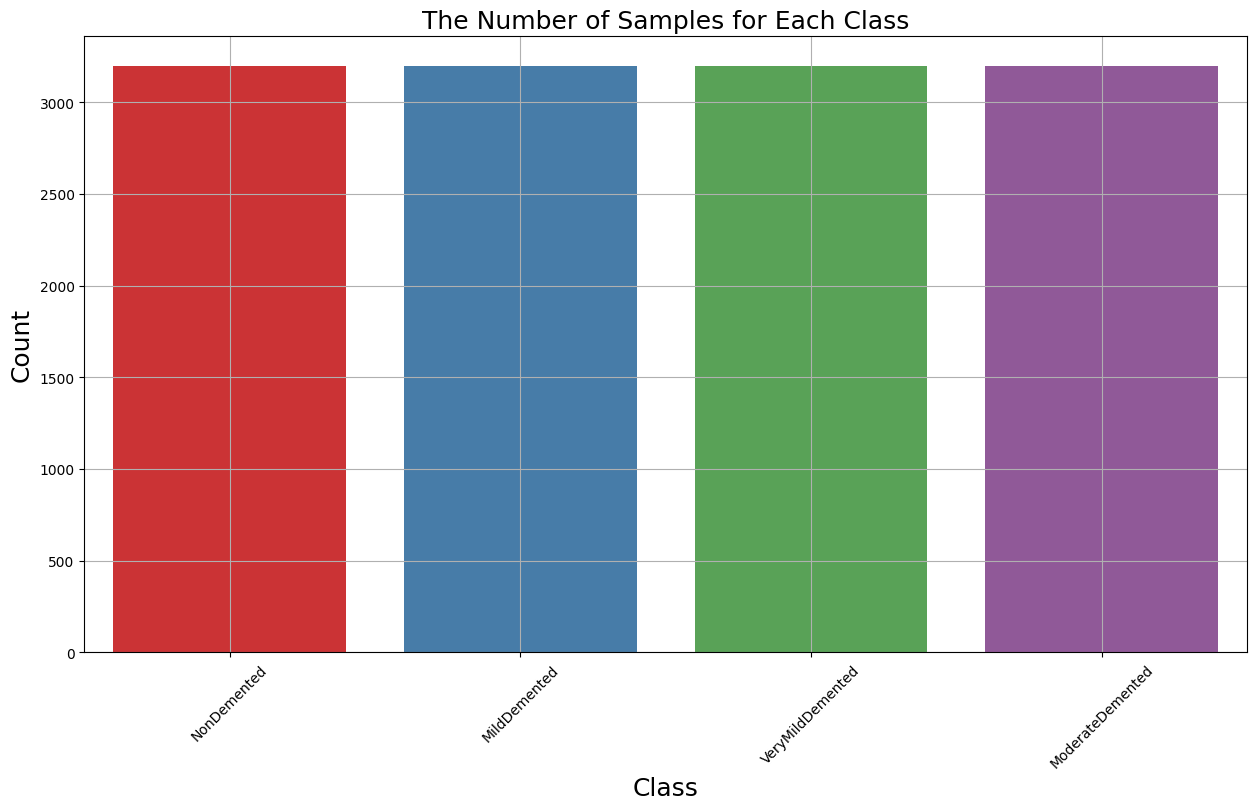

In [30]:
plot_class_distribution(train_labels,CLASSES)

**Now the number of samples for each class is equal, the dataset is balanced**

> Splitting the Data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
X_train1,X_val,y_train1,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [32]:
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (10240, 224, 224, 3)
X_test shape is  (2560, 224, 224, 3)
X_val shape is  (2048, 224, 224, 3)
y_train shape is  (10240, 4)
y_test shape is  (2560, 4)
y_val shape is  (2048, 4)


# **Modelling**

**1. Inception Model**

In [33]:
custom_inception = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 0s 0us/step


In [34]:
for layer in custom_inception.layers:
    layer.trainable=False

In [35]:
custom_inception = Sequential([
        custom_inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ], name = "inception_cnn_model")

In [36]:
custom_inception.compile(optimizer='Adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

In [37]:
history_custom_inception = custom_inception.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
320/320 [==============================] - 87s 251ms/step - loss: 1.3556 - acc: 0.4134 - auc: 0.6854 - val_loss: 0.7936 - val_acc: 0.6455 - val_auc: 0.8922 - lr: 0.0010
Epoch 2/100
320/320 [==============================] - 77s 240ms/step - loss: 0.9117 - acc: 0.5778 - auc: 0.8444 - val_loss: 0.6482 - val_acc: 0.6934 - val_auc: 0.9239 - lr: 0.0010
Epoch 3/100
320/320 [==============================] - 77s 239ms/step - loss: 0.7893 - acc: 0.6388 - auc: 0.8849 - val_loss: 0.5944 - val_acc: 0.7266 - val_auc: 0.9346 - lr: 0.0010
Epoch 4/100
320/320 [==============================] - 76s 239ms/step - loss: 0.7350 - acc: 0.6646 - auc: 0.9009 - val_loss: 0.5601 - val_acc: 0.7407 - val_auc: 0.9439 - lr: 0.0010
Epoch 5/100
320/320 [==============================] - 77s 239ms/step - loss: 0.6984 - acc: 0.6832 - auc: 0.9110 - val_loss: 0.5283 - val_acc: 0.7676 - val_auc: 0.9502 - lr: 0.0010
Epoch 6/100
320/320 [==============================] - 77s 240ms/step - loss: 0.6701 - acc: 0.6

In [39]:
print_model_metrics(custom_inception,X_train,y_train,X_test,y_test)

80/80 [==============================] - 16s 199ms/step - loss: 0.2657 - acc: 0.9090 - auc: 0.9883
Training Accuracy: 99.98%
Testing Accuracy: 90.90%


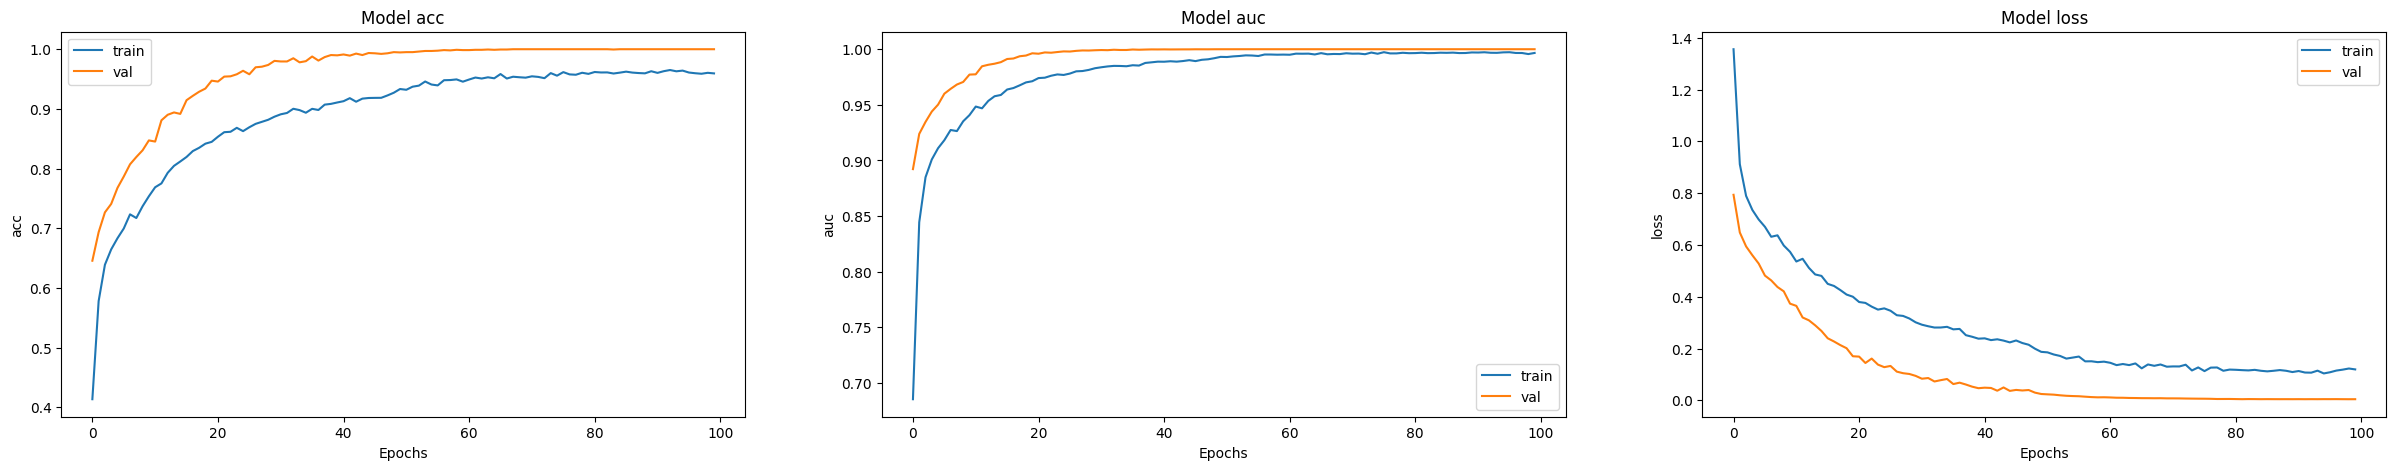

In [40]:
plot_training_history(history_custom_inception)

In [41]:
custom_inception.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)       

In [43]:
pred_labels_custom_inception = custom_inception.predict(X_test)

80/80 [==============================] - 18s 205ms/step


In [44]:
rounded_predictions = apply_roundoff_to_predictions(pred_labels_custom_inception)

print(classification_report(y_test, rounded_predictions, target_names=CLASSES))

                  precision    recall  f1-score   support

    MildDemented       0.93      0.96      0.95       611
ModerateDemented       1.00      1.00      1.00       631
     NonDemented       0.87      0.83      0.85       658
VeryMildDemented       0.84      0.85      0.84       660

       micro avg       0.91      0.91      0.91      2560
       macro avg       0.91      0.91      0.91      2560
    weighted avg       0.91      0.91      0.91      2560
     samples avg       0.91      0.91      0.91      2560



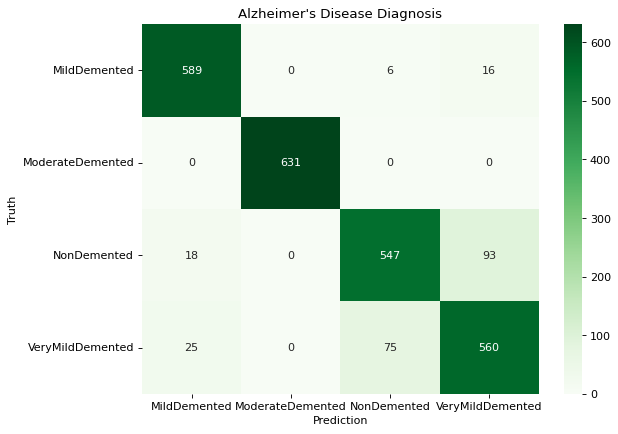

In [46]:
pred_ls_custom_inception = np.argmax(pred_labels_custom_inception, axis=1)
test_ls_custom_inception = np.argmax(y_test, axis=1)
plot_confusion_matrix(test_ls_custom_inception, pred_ls_custom_inception, CLASSES)

In [47]:
print_metrics(test_ls_custom_inception,pred_ls_custom_inception)

Balanced Accuracy Score : 91.09 %
Matthew's Correlation Coefficient: 87.88 %


In [ ]:
%%shell
jupyter nbconvert --to html /content/Alzheimers_Detection.ipynb

[NbConvertApp] Converting notebook /content/Alzheimers_Detection.ipynb to html
[NbConvertApp] Writing 1550325 bytes to /content/Alzheimers_Detection.html
